In [ ]:
!pip install transformers datasets albumentations torchinfo torchmetrics opencv-python evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
import datasets, transformers, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
import albumentations as A
from datasets import load_dataset
from huggingface_hub import notebook_login, hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm
import evaluate

import os, random
from pathlib import Path
import json

In [ ]:
notebook_login()

In [ ]:
dataset = load_dataset("BhavanaMalla/railsem19-semantic-split355-expanded")

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
dataset

In [ ]:
def get_labels():
    data_directory = Path(".")
    json_file_path = data_directory / "labels_info.json"
    if json_file_path.is_file():
        print(f"[INFO]: Found {json_file_path}.Skipping Download...")
    else:
        print("[INFO]: Downloading labels_info.json from hub")
        json_file_path = hf_hub_download(
            repo_id="BhavanaMalla/railsem19-semantic",
            filename="labels_info.json",
            repo_type="dataset",
            local_dir=data_directory
        )
    with open(json_file_path, "r") as f:
        labels_info = json.load(f)
    return labels_info

In [ ]:
from transformers import OneFormerForUniversalSegmentation, AutoProcessor

labels_info = get_labels()
id2label = labels_info["id2label"]

ckpt = "shi-labs/oneformer_cityscapes_swin_large"
model = OneFormerForUniversalSegmentation.from_pretrained(
        ckpt,
        is_training=True,
        id2label=id2label,
        ignore_mismatched_sizes=True
    )

processor = AutoProcessor.from_pretrained(
    ckpt,
    do_reduce_labels=False,
    do_normalize=False,
    do_rescale=False,
    do_resize=False
)

processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

[INFO]: Downloading labels_info.json from hub


labels_info.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/77.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/879M [00:00<?, ?B/s]

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_cityscapes_swin_large and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.3.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_projector.layers.1.0.bias', 'model.text_mapper.text_encoder.transformer.layers.1.mlp.fc1.bias', 'model.text_mapper.text_projector.layers.1.0.weight', 'model.text_mapper.text_encoder.transformer.layers.3.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.4.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.4.self_attn.in_proj_bias', 'model.text_mapper.text_encoder.transformer.layers.4.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.transformer.layers.5.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.transformer.layers.5.s

preprocessor_config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


cityscapes_panoptic.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [ ]:
processor.image_processor

OneFormerImageProcessor {
  "_max_size": 2048,
  "class_info_file": "cityscapes_panoptic.json",
  "do_normalize": false,
  "do_reduce_labels": false,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "OneFormerImageProcessor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "metadata": {
    "0": "road",
    "1": "building",
    "10": "sky",
    "11": "person",
    "12": "rider",
    "13": "car",
    "14": "truck",
    "15": "bus",
    "16": "train",
    "17": "motorcycle",
    "18": "bicycle",
    "2": "sidewalk",
    "3": "wall",
    "4": "fence",
    "5": "pole",
    "6": "traffic light",
    "7": "traffic sign",
    "8": "vegetation",
    "9": "terrain",
    "class_names": [
      "road",
      "building",
      "sidewalk",
      "wall",
      "fence",
      "pole",
      "traffic light",
      "tr

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        semantic_mask = self.dataset[idx]["semantic_mask_label"]
        semantic_mask = np.array(semantic_mask)
        original_image = np.array(image)
        target_mask = np.array(semantic_mask)
        if self.transforms:
            transformed = self.transforms(image=original_image,
                                          mask=target_mask)
            image, semantic_mask = transformed["image"], transformed["mask"]
            image = image.transpose(2, 0, 1)

        return image, semantic_mask, original_image, target_mask

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    batch = processor(images,
                      segmentation_maps=segmentation_maps,
                      task_inputs=["semantic"] * len(images),
                      return_tensors="pt")
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    return batch

# Transforms
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
train_transforms = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=MEAN, std=STD),
])

val_transforms = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])

In [ ]:
train_sub = dataset["train"].select(range(4))
val_sub = dataset["validation"].select(range(4))

train_dataset = CustomDataset(train_sub, train_transforms)
val_dataset = CustomDataset(val_sub, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
#type(next(iter(train_dataloader)))#[0].shape
len(next(iter(train_dataloader))["pixel_values"]), train_dataloader.batch_size#[0].shape

(2, 2)

In [ ]:
id2label

{'0': 'road',
 '1': 'sidewalk',
 '2': 'construction',
 '3': 'tram-track',
 '4': 'fence',
 '5': 'pole',
 '6': 'traffic-light',
 '7': 'traffic-sign',
 '8': 'vegetation',
 '9': 'terrain',
 '10': 'sky',
 '11': 'human',
 '12': 'rail-track',
 '13': 'car',
 '14': 'truck',
 '15': 'trackbed',
 '16': 'on-rails',
 '17': 'rail-raised',
 '18': 'rail-embedded'}

     post_process_instance_segmentation
     `List[Dict]`: A list of dictionaries, one per image, each dictionary containing two keys:
            - *segmentation** -- a tensor of shape `(height, width)` where each pixel represents a `segment_id`, set
              to `None` if no mask if found above `threshold`. If `target_sizes` is specified, segmentation is resized
              to the corresponding `target_sizes` entry.
            - **segments_info** -- A dictionary that contains additional information on each segment.
                - **id** -- an integer representing the `segment_id`.
                - **label_id** -- An integer representing the label / semantic class id corresponding to `segment_id`.
                - **was_fused** -- a boolean, `True` if `label_id` was in `label_ids_to_fuse`, `False` otherwise.
                  Multiple instances of the same class / label were fused and assigned a single `segment_id`.
                - **score** -- Prediction score of segment with `segment_id`.

In [ ]:
# Plot the preds

def plot_predictions(images, ground_truth_mask, predicted_mask, palette):
    palette = np.array(palette)
    num_images = len(images)

    cols = 3  # 3 cols: original image, gt mask, segmentation mask

    # Create a subplot with num_images rows and 3 columns, make it 5 if you want classes
    fig, axes = plt.subplots(num_images, cols, figsize=(15, 5*num_images))
    # Titles
    axes[0, 0].set_title("Original Image")
    axes[0, 1].set_title("Ground Truth Mask")
    axes[0, 2].set_title("Predicted Mask")

    for i, (img, gt_mask, pred_mask) in enumerate(zip(images, ground_truth_mask, predicted_mask)):
        gt_classes_map = np.unique(gt_mask).tolist()
        unique_classes_pred = [model.config.id2label[str(idx)] if idx!=255 else "Background" for idx in gt_classes_map]

        pred_classes_map = np.unique(pred_mask).tolist()
        unique_classes_gt = [model.config.id2label[str(idx)] if idx!=255 else "Background" for idx in pred_classes_map]

        color_seg = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8) # height, width, 3
        color_seg_gt = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(palette):
            color_seg[pred_mask == label, :] = color
            color_seg_gt[gt_mask == label, :] = color

        # Convert to BGR
        color_seg = color_seg[..., ::-1]
        color_seg_gt = color_seg_gt[..., ::-1]

        # Show image + mask of prediction
        img_pred = np.array(img) * 0.5 + color_seg * 0.5
        img_pred = img_pred.astype(np.uint8)

        # Show image + mask of gt
        img_gt = np.array(img) * 0.5 + color_seg_gt * 0.5
        img_gt = img_gt.astype(np.uint8)

        # Plot original image
        axes[i, 0].imshow(img)
        # Plot ground truth mask
        axes[i, 1].imshow(img_gt)
        # Plot predicted mask
        axes[i, 2].imshow(img_pred)

        # # Show predicted classes and ground truth classes
        # axes[0, 3].set_title("GT Classes")
        # axes[0, 4].set_title("Predicted Classes")
        # axes[i, 3].text(0.5, 0.5, "\n".join(unique_classes_gt), fontsize=8, va="center", ha="center", transform=axes[i, 3].transAxes)
        # axes[i, 4].text(0.5, 0.5, "\n".join(unique_classes_pred), fontsize=8, va="center", ha="center", transform=axes[i, 4].transAxes)

    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Print overall metrics
def show_metrics(metrics):
    for key in list(metrics.keys())[:3]:
        print(key, metrics[key])
    # pretty-print per category metrics as Pandas DataFrame
    metric_table = dict()
    for id, label in id2label.items():
        metric_table[label] = [
            metrics["per_category_iou"][int(id)],
            metrics["per_category_accuracy"][int(id)]
        ]
    print("\n---------------------")
    print("Per-Category Metrics:")
    print("---------------------\n")
    per_category_df = pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])
    print(per_category_df)

In [ ]:
#processor.image_processor.post_process_semantic_segmentation

In [ ]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
metric = evaluate.load("mean_iou")
palette = labels_info["color_palette"]
model.model.is_training = False
model.eval()
for step, batch in tqdm(enumerate(val_dataloader)):
    batch_dict = {
        "pixel_values": batch["pixel_values"],
        "pixel_mask": batch["pixel_mask"],
        "task_inputs": batch["task_inputs"],
    }
    batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else [x.to(device) for x in v] for k, v in batch_dict.items()}
    with torch.inference_mode():
        eval_outputs = model(**batch_dict) #['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'task_token', 'attentions']
    # Post process segmentation
    original_images = batch["original_images"]
    target_sizes = [(img.shape[0], img.shape[1]) for img in original_images]
    predicted_segmentation_maps = processor.post_process_semantic_segmentation(eval_outputs, target_sizes=target_sizes) # list(dicts), dict per image, each dict has 2 keys, List[Dicts] =[{segmentation - shape(h, w) with segment id/pixel, segments_info - dict{segmntid, labelid, wasfused, score}}]

    # Get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    metric.add_batch(references=ground_truth_segmentation_maps,
                     predictions=predicted_segmentation_maps)
    if step == len(val_dataloader) - 1:
        plot_predictions(
            images=batch["original_images"],
            ground_truth_mask=batch["original_segmentation_maps"],
            predicted_mask=predicted_segmentation_maps,
            palette=palette)
    del batch

metrics = metric.compute(num_labels=19, ignore_index=255)
show_metrics(metrics)


In [ ]:
type(predicted_segmentation_maps), type(predicted_segmentation_maps[0]), torch.unique(predicted_segmentation_maps[0]), torch.unique(predicted_segmentation_maps[1])

(list,
 torch.Tensor,
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13]),
 tensor([ 0,  2,  4,  5,  7,  8,  9, 10, 13]))

In [ ]:
batch["original_images"][0].shape, batch["pixel_values"][0].shape, eval_outputs["class_queries_logits"].shape, eval_outputs["masks_queries_logits"].shape, target_sizes, predicted_segmentation_maps[0].shape, batch["original_segmentation_maps"][0].shape

((1080, 1920, 3),
 torch.Size([3, 512, 512]),
 torch.Size([2, 250, 20]),
 torch.Size([2, 250, 128, 128]),
 [(1080, 1920), (1080, 1920)],
 torch.Size([1080, 1920]),
 (1080, 1920))

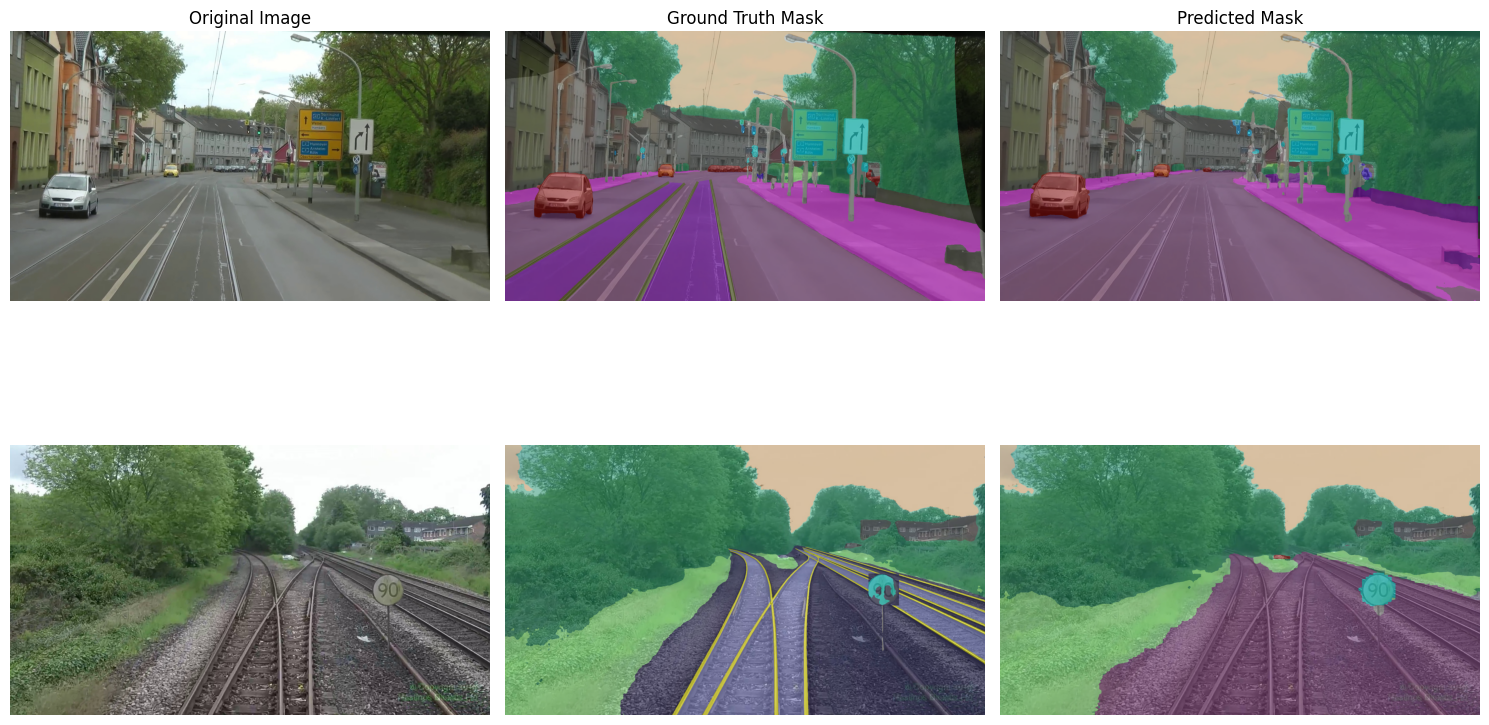

In [ ]:
palette = labels_info["color_palette"]

plot_predictions(images=batch["original_images"],
                 ground_truth_mask=batch["original_segmentation_maps"],
                 predicted_mask=predicted_segmentation_maps,
                 palette=palette)

In [ ]:
show_metrics(metrics)

mean_iou 0.33755737627940396
mean_accuracy 0.4372283530769729
overall_accuracy 0.7042499749683495

---------------------
Per-Category Metrics:
---------------------

                    IoU  accuracy
road           0.256422  0.905621
sidewalk       0.627863  0.714134
construction   0.719672  0.820612
tram-track     0.000000  0.000000
fence          0.239792  0.505301
pole           0.404054  0.590209
traffic-light  0.143733  0.164773
traffic-sign   0.748141  0.897867
vegetation     0.884747  0.941489
terrain        0.618102  0.814335
sky            0.970175  0.985338
human          0.007038  0.061321
rail-track     0.000000  0.000000
car            0.783163  0.894768
truck          0.000090  0.000944
trackbed       0.000000  0.000000
on-rails       0.010598  0.010626
rail-raised    0.000000  0.000000
rail-embedded  0.000000  0.000000


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
        num_rows: 500
    })
    test: Dataset({
        features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
        num_rows: 500
    })
})

In [ ]:
len(dataset["train"]["objs_labels"]), dataset["train"]["objs_labels"][0]

(3000,
 ['track-sign-front',
  'track-sign-front',
  'track-sign-front',
  'rail-occluder',
  'pole',
  'person',
  'person-group',
  'person-group',
  'rail',
  'rail',
  'rail',
  'rail',
  'rail'])

In [ ]:
# Flatten the list of lists
flattened_labels = np.concatenate(dataset["train"]["objs_labels"]).ravel().tolist()
print(len(flattened_labels))

# Get unique values
unique_values, counts = np.unique(flattened_labels, return_counts=True)
# Print the unique values
print(len(unique_values)) #see these are from individual json labels
print(unique_values)
print(counts)

30682
21
['buffer-stop' 'car' 'crossing' 'fence' 'guard-rail' 'person'
 'person-group' 'platform' 'pole' 'rail' 'rail-occluder'
 'switch-indicator' 'switch-left' 'switch-right' 'switch-static'
 'switch-unknown' 'track-sign-front' 'track-signal-back'
 'track-signal-front' 'train-car' 'truck']
[   84    62  1043   108  1619    84    22   867  3953 10902  1408   669
   694   708   871   875  2695  1274  2036   705     3]


In [ ]:
labels_info = get_labels()
id2label = labels_info["id2label"]

id2label #these are from single json file, both are different

[INFO]: Found labels_info.json.Skipping Download...


{'0': 'road',
 '1': 'sidewalk',
 '2': 'construction',
 '3': 'tram-track',
 '4': 'fence',
 '5': 'pole',
 '6': 'traffic-light',
 '7': 'traffic-sign',
 '8': 'vegetation',
 '9': 'terrain',
 '10': 'sky',
 '11': 'human',
 '12': 'rail-track',
 '13': 'car',
 '14': 'truck',
 '15': 'trackbed',
 '16': 'on-rails',
 '17': 'rail-raised',
 '18': 'rail-embedded'}

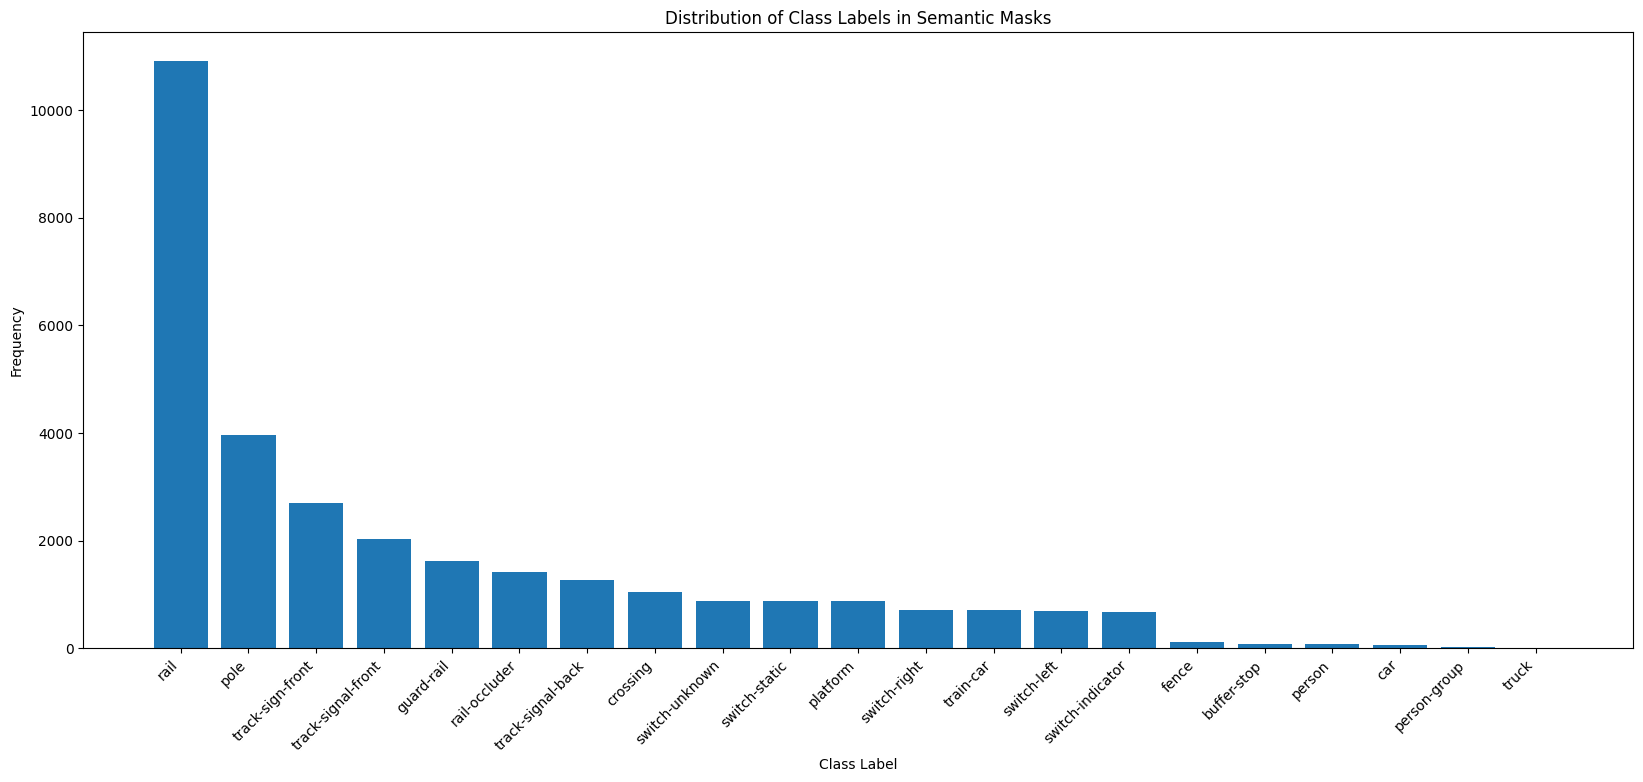

In [ ]:
# Flatten the list of lists
flattened_labels = np.concatenate(dataset["train"]["objs_labels"]).ravel().tolist()

# Get unique values
unique_values, counts = np.unique(flattened_labels, return_counts=True)

# Sort unique values based on counts
sorted_indices = np.argsort(counts)[::-1]
unique_values = unique_values[sorted_indices]
counts = counts[sorted_indices]

# Create a bar plot
plt.figure(figsize=(20, 8))
plt.bar(unique_values, counts)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels in Semantic Masks')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

In [ ]:
np.array(dataset["train"][0]["semantic_mask_label"], dtype=np.uint8).shape

(1080, 1920)

In [ ]:
np.array(dataset["train"][1]["semantic_mask_label"], dtype=np.uint8).shape

(1080, 1920)

In [ ]:
np.array(dataset["train"][2]["semantic_mask_label"], dtype=np.uint8).shape

(1080, 1920)

In [ ]:
from PIL import Image

img = Image.open("/content/drive/MyDrive/Colab Notebooks/Master Thesis/Data/railsem19/rs00000.jpg")
img = np.array(img)
mask = Image.open("/content/drive/MyDrive/Colab Notebooks/Master Thesis/Data/railsem19/rs00000.png")
mask = np.array(mask)
np.unique(mask)

array([  0,   1,   2,   5,   8,   9,  10,  12,  13,  15,  17, 255],
      dtype=uint8)

In [ ]:
mask = np.array(dataset["train"][0]["semantic_mask_label"])
np.unique(mask)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  18,
       255], dtype=uint8)

In [ ]:
mask = dataset["train"][0]["semantic_mask_label"]
convert_tensor = transforms.ToTensor() #automatically normalizes, so avoid this
tr_img = convert_tensor(mask)
tr_img

tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118]]])

In [ ]:
# from torchvision.transforms.functional import F_pil
#  class ConvertPilToTensorTransform:
#     def __call__(self, pil_img):
        # img = torch.as_tensor(np.array(pil_img, copy=True))
        # img = img.view(pil_img.size[1], pil_img.size[0], F_pil.get_image_num_channels(pil_img))
        # img = img.permute((2, 0, 1))  # put it from HWC to CHW format
        # return img

#  data_transform = transforms.Compose([
#     #transforms.ToTensor(), #avoid this
#     ConvertPilToTensorTransform(),  # Add the custom transform here
# ])

In [ ]:
 # handle PIL Image
 from torchvision.transforms.functional import pil_to_tensor

 mask = dataset["train"][0]["semantic_mask_label"]
 tr_mask = pil_to_tensor(mask)

 torch.unique(tr_mask)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  18, 255],
       dtype=torch.uint8)

In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
     transforms.PILToTensor()
])

mask = dataset["train"][0]["semantic_mask_label"]
tr_mask = data_transform(mask)
torch.unique(tr_mask)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  18, 255],
       dtype=torch.uint8)

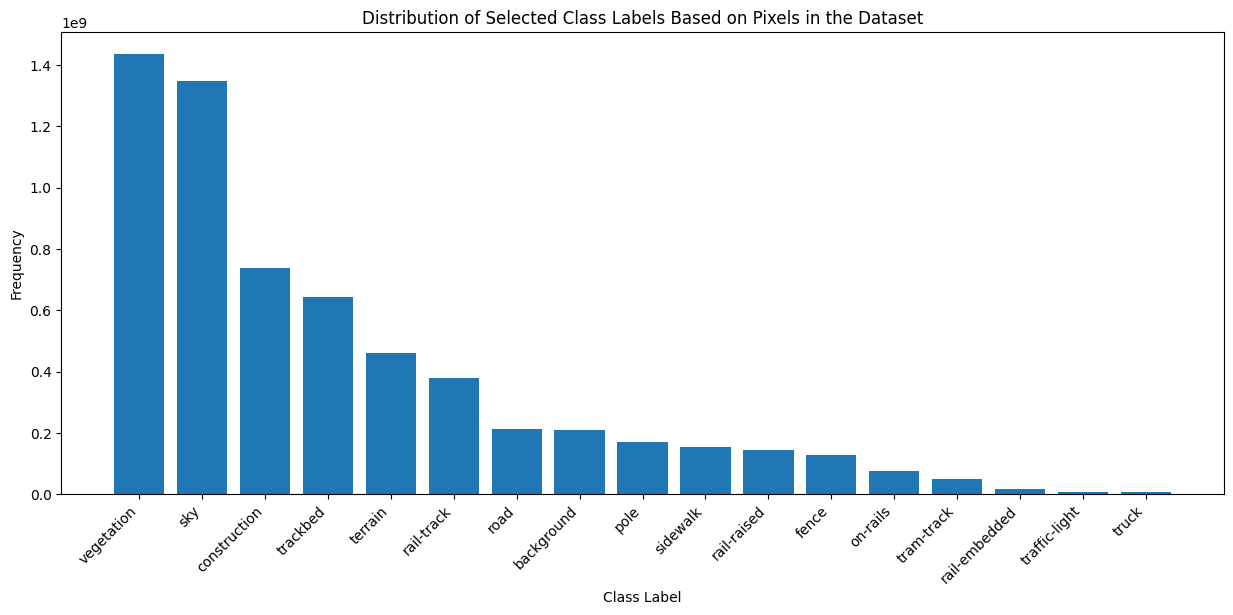

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, semantic_masks, transform):
        self.semantic_masks = semantic_masks
        self.transform = transform

    def __len__(self):
        return len(self.semantic_masks)

    def __getitem__(self, idx):
        mask = self.semantic_masks[idx]

        if self.transform:
            tr_mask = self.transform(mask)

        return tr_mask

# Define the transformation
data_transform = transforms.Compose([
    transforms.PILToTensor(),
])

# Create a custom dataset
custom_dataset = CustomDataset(dataset["train"]["semantic_mask_label"], transform=data_transform)

# Create a DataLoader to handle batching
batch_size = 2
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Accumulate class frequencies
class_frequencies = {}

for batch in data_loader:
    # Flatten the batch tensor along the height and width dimensions
    flat_batch = batch.view(batch.size(0), -1) #(2, 2073600)

    # Count the occurrences of each class label in the batch
    unique_labels, label_counts = torch.unique(flat_batch, return_counts=True) #17, 17

    # Update class frequencies dictionary
    for label, count in zip(unique_labels, label_counts):
        label_item = label.item()
        if label_item in [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18, 255]:

            if label_item not in class_frequencies:
                class_frequencies[label_item] = count.item()
            else:
                class_frequencies[label_item] += count.item()
    del batch

# Plot the distribution of class frequencies
plt.figure(figsize=(15, 6))
labels, frequencies = zip(*class_frequencies.items())

# Include the background label without remapping
labels = [id2label[str(i)] if i !=255 else "background" for i in labels]

# Sort based on frequencies
sorted_indices = np.argsort(frequencies)[::-1]
frequencies = np.array(frequencies)[sorted_indices]
labels = np.array(labels)[sorted_indices]

# Figure plot
plt.bar(labels, frequencies)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Selected Class Labels Based on Pixels in the Dataset')
plt.show()

In [ ]:
unique_labels, label_counts, class_frequencies

(tensor([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  12,  14,  15,  16,
          17,  18, 255], dtype=torch.uint8),
 tensor([  29609,   14560,  116838,   11769,   29511,   97551,      63,  711134,
          461966, 1534149,  313906,      73,  590415,   41209,  185886,    6148,
            2413]),
 {0: 210950946,
  1: 154017369,
  2: 737772711,
  3: 50333619,
  4: 127304617,
  5: 169498139,
  6: 8312624,
  8: 1436245852,
  9: 459797900,
  10: 1348733922,
  12: 379655511,
  15: 642478167,
  16: 75357708,
  17: 145280866,
  18: 16770198,
  255: 208510757,
  14: 7793961})

In [ ]:
id2label

{'0': 'road',
 '1': 'sidewalk',
 '2': 'construction',
 '3': 'tram-track',
 '4': 'fence',
 '5': 'pole',
 '6': 'traffic-light',
 '7': 'traffic-sign',
 '8': 'vegetation',
 '9': 'terrain',
 '10': 'sky',
 '11': 'human',
 '12': 'rail-track',
 '13': 'car',
 '14': 'truck',
 '15': 'trackbed',
 '16': 'on-rails',
 '17': 'rail-raised',
 '18': 'rail-embedded'}

In [ ]:
import matplotlib.pyplot as plt

# Assuming class_counts is your dictionary {clslabel1: counts, clslabel2: counts, ...}
class_labels = list(class_frequencies.keys())
class_counts_values = list(class_frequencies.values())
# Map class labels to their corresponding names using id2label
class_labels_mapped = [id2label[str(label)] if label != 255 else "background" for label in class_labels]


# Plot the distribution
plt.figure(figsize=(15, 6))
plt.bar(class_labels, class_counts_values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels based on pixels')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, semantic_masks, transform):
        self.semantic_masks = semantic_masks
        self.transform = transform

    def __len__(self):
        return len(self.semantic_masks)

    def __getitem__(self, idx):
        mask = self.semantic_masks[idx]

        if self.transform:
            tr_mask = self.transform(mask)

        return tr_mask

# Define the transformation
data_transform = transforms.Compose([
    transforms.PILToTensor(),
])

# Create a custom dataset
custom_dataset = CustomDataset(dataset["train"]["semantic_mask_label"], transform=data_transform)

# Create a DataLoader to handle batching
batch_size = 2
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Define class indices
CLASS_INDICES = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18, 255]  # Add all relevant class indices

# Initialize a list to store results
rows = []
for batch in data_loader:
    for image in batch:
        # Flatten the image tensor
        flat_image = image.view(-1)

        # Find unique labels and their counts
        unique_labels, label_counts = torch.unique(flat_image, return_counts=True)

        # Append the results to the lists
        unique_labels_list = unique_labels.tolist()
        label_counts_list = label_counts.tolist()
        num_objs_labels = len(unique_labels_list)
        area_of_objects = [round((cnt / (image.shape[1] * image.shape[2])), 4) for cnt in label_counts_list]
        rows.append([unique_labels_list, label_counts_list, num_objs_labels, area_of_objects])
# Convert rows to a DataFrame
df = pd.DataFrame(rows, columns=['Unique Labels', 'Label Counts', 'Num Objects Labels', 'Area of Objects'])

In [ ]:
unique_labels_list, label_counts_list, num_objs_labels, area_of_objects

([0, 1, 2, 3, 4, 5, 8, 9, 10, 12, 14, 15, 16, 17, 18, 255],
 [29609,
  12169,
  116838,
  11769,
  29511,
  76846,
  102538,
  395974,
  838173,
  125330,
  73,
  170702,
  41209,
  114298,
  6148,
  2413],
 16,
 [0.0143,
  0.0059,
  0.0563,
  0.0057,
  0.0142,
  0.0371,
  0.0494,
  0.191,
  0.4042,
  0.0604,
  0.0,
  0.0823,
  0.0199,
  0.0551,
  0.003,
  0.0012])

In [ ]:
df.head()

,Unique Labels,Label Counts,Num Objects Labels,Area of Objects
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 18, 255]","[624717, 89822, 970974, 122994, 2949, 3924, 31...",14,"[0.3013, 0.0433, 0.4683, 0.0593, 0.0014, 0.001..."
1,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]","[78252, 17596, 130932, 30541, 153414, 16101, 6...",14,"[0.0377, 0.0085, 0.0631, 0.0147, 0.074, 0.0078..."
2,"[2, 4, 5, 7, 8, 10, 12, 15, 16, 17, 255]","[238338, 88445, 4951, 404, 556971, 725134, 101...",11,"[0.1149, 0.0427, 0.0024, 0.0002, 0.2686, 0.349..."
3,"[0, 1, 2, 4, 5, 7, 8, 9, 10, 12, 15, 17, 255]","[5360, 94488, 87111, 2303, 11864, 3847, 119007...",13,"[0.0026, 0.0456, 0.042, 0.0011, 0.0057, 0.0019..."
4,"[0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...","[225023, 26894, 120420, 59673, 36676, 140894, ...",15,"[0.1085, 0.013, 0.0581, 0.0288, 0.0177, 0.0679..."


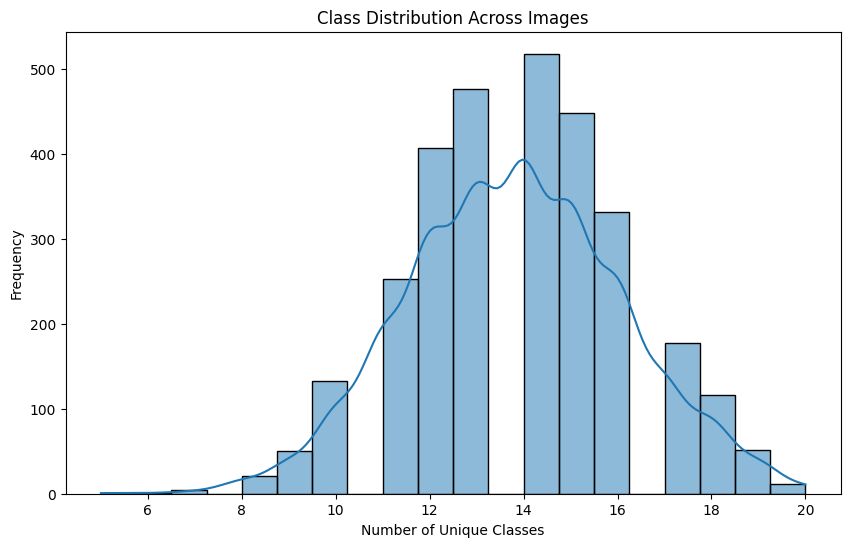

In [ ]:
import seaborn as sns

# 1. Class Distribution
class_distribution = df['Unique Labels'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.histplot(class_distribution, bins=20, kde=True)
plt.title('Class Distribution Across Images')
plt.xlabel('Number of Unique Classes')
plt.ylabel('Frequency')
plt.show()

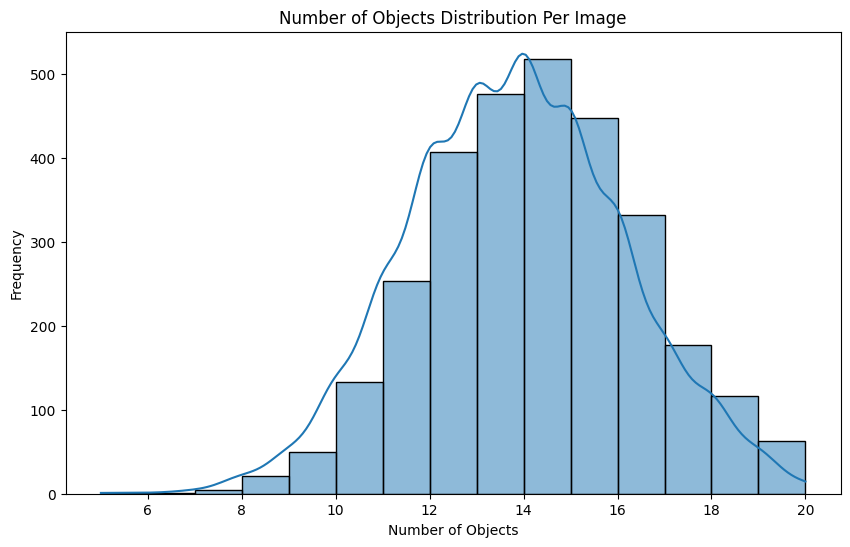

In [ ]:
# 2. Number of Objects Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Num Objects Labels'], bins=15, kde=True)
plt.title('Number of Objects Distribution Per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.show()

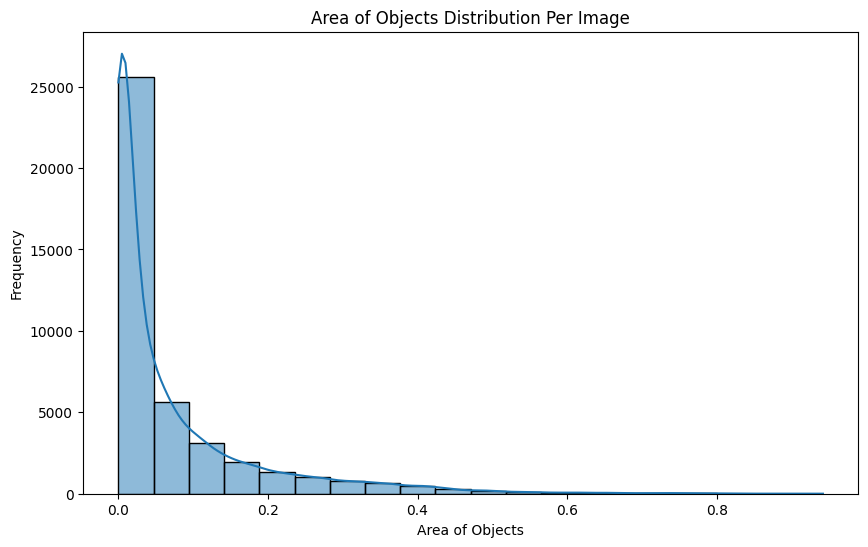

In [ ]:
# 3. Area of Objects Distribution
plt.figure(figsize=(10, 6))
#sns.histplot([round(float(area), 6) for sublist in df['Area of Objects'] for area in sublist], bins=20, kde=True)
sns.histplot([area for sublist in df['Area of Objects'] for area in sublist], bins=20, kde=True)
plt.title('Area of Objects Distribution Per Image')
plt.xlabel('Area of Objects')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 6. Aggregate Statistics
aggregate_stats = df[['Num Objects Labels', 'Area of Objects']].describe()

# Displaying the aggregate statistics
print("Aggregate Statistics:")
print(aggregate_stats)

Aggregate Statistics:
       Num Objects Labels
count         3000.000000
mean            13.810667
std              2.286605
min              5.000000
25%             12.000000
50%             14.000000
75%             15.000000
max             20.000000


In [ ]:
# 7. Outlier Detection
outliers = df[df['Num Objects Labels'] > df['Num Objects Labels'].mean() + 2 * df['Num Objects Labels'].std()]
outliers
# You can customize the outlier detection criterion based on your dataset

,Unique Labels,Label Counts,Num Objects Labels,Area of Objects
15,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[38992, 5829, 27237, 11878, 136412, 37670, 259...",19,"[0.0188, 0.0028, 0.0131, 0.0057, 0.0658, 0.018..."
52,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[5972, 159, 13974, 1211, 2361, 2199, 299, 1157...",19,"[0.0029, 0.0001, 0.0067, 0.0006, 0.0011, 0.001..."
69,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[323778, 58567, 77882, 123155, 10080, 134853, ...",19,"[0.1561, 0.0282, 0.0376, 0.0594, 0.0049, 0.065..."
80,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[122655, 75950, 192600, 14648, 60396, 156431, ...",19,"[0.0592, 0.0366, 0.0929, 0.0071, 0.0291, 0.075..."
150,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[248050, 33168, 2567, 17084, 220456, 38365, 45...",19,"[0.1196, 0.016, 0.0012, 0.0082, 0.1063, 0.0185..."
...,...,...,...,...
2657,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[5480, 405404, 407601, 17053, 15252, 85668, 49...",19,"[0.0026, 0.1955, 0.1966, 0.0082, 0.0074, 0.041..."
2763,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[293673, 8, 28211, 263471, 62150, 94258, 7452,...",19,"[0.1416, 0.0, 0.0136, 0.1271, 0.03, 0.0455, 0...."
2807,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[725102, 99917, 224388, 87169, 2509, 71024, 38...",20,"[0.3497, 0.0482, 0.1082, 0.042, 0.0012, 0.0343..."
2874,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[494834, 13315, 95534, 54418, 138815, 33840, 1...",19,"[0.2386, 0.0064, 0.0461, 0.0262, 0.0669, 0.016..."


In [ ]:
id2label

{'0': 'road',
 '1': 'sidewalk',
 '2': 'construction',
 '3': 'tram-track',
 '4': 'fence',
 '5': 'pole',
 '6': 'traffic-light',
 '7': 'traffic-sign',
 '8': 'vegetation',
 '9': 'terrain',
 '10': 'sky',
 '11': 'human',
 '12': 'rail-track',
 '13': 'car',
 '14': 'truck',
 '15': 'trackbed',
 '16': 'on-rails',
 '17': 'rail-raised',
 '18': 'rail-embedded'}

    Label    Area
0       0  0.3013
1       1  0.0433
2       2  0.4683
3       3  0.0593
4       4  0.0014
5       5  0.0019
6       6  0.0000
7       7  0.0009
8       8  0.0170
9      10  0.0001
10     11  0.0132
11     13  0.0066
12     18  0.0462
13    255  0.0404
14      0  0.0377
15      1  0.0085
16      2  0.0631
17      4  0.0147
18      5  0.0740
19      6  0.0078
Label
0      101.7275
1       74.2728
2      355.7918
3       24.2740
4       61.3900
5       81.7415
6        4.0073
7        4.0256
8      692.6335
9      221.7368
10     650.4306
11       4.2334
12     183.0910
13      11.9784
14       3.7575
15     309.8375
16      36.3402
17      70.0628
18       8.0865
255    100.5487
Name: Area, dtype: float64


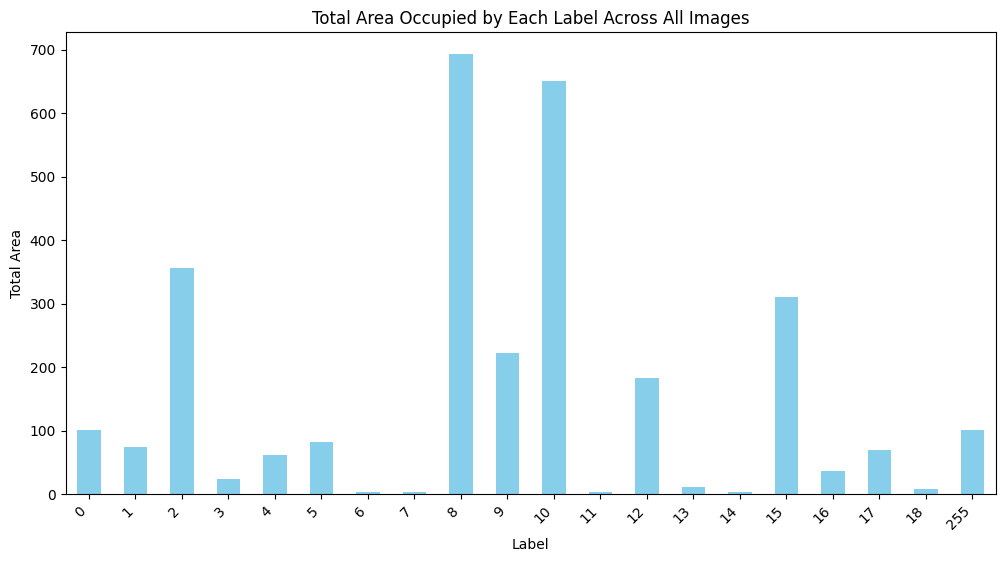

In [ ]:
# Flatten the lists in 'Unique Labels' and 'Area of Objects' columns
flat_labels = [label for labels_list in df['Unique Labels'] for label in labels_list]
flat_areas = [area for areas_list in df['Area of Objects'] for area in areas_list]
# Create a DataFrame with flattened data
area_df = pd.DataFrame({'Label': flat_labels, 'Area': flat_areas})

# Group by label and sum the areas
label_areas = area_df.groupby('Label')['Area'].sum()
print(area_df.head(20))
print(label_areas)

# Plot the histogram or bar plot
plt.figure(figsize=(12, 6))
label_areas.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Total Area')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Total Area Occupied by Each Label Across All Images')
plt.show()

['road', 'sidewalk', 'construction', 'tram-track', 'fence', 'pole', 'traffic-light', 'traffic-sign', 'vegetation', 'sky', 'human', 'car', 'rail-embedded', 'Background', 'road', 'sidewalk', 'construction', 'fence', 'pole', 'traffic-light', 'traffic-sign', 'vegetation', 'terrain', 'sky', 'rail-track', 'trackbed', 'on-rails', 'rail-raised', 'construction', 'fence', 'pole', 'traffic-sign', 'vegetation', 'sky', 'rail-track', 'trackbed', 'on-rails', 'rail-raised', 'Background', 'road', 'sidewalk', 'construction', 'fence', 'pole', 'traffic-sign', 'vegetation', 'terrain', 'sky', 'rail-track', 'trackbed', 'rail-raised', 'Background', 'road', 'sidewalk', 'construction', 'fence', 'pole', 'vegetation', 'terrain', 'sky', 'human', 'rail-track', 'car', 'truck', 'trackbed', 'on-rails', 'rail-raised', 'road', 'sidewalk', 'construction', 'fence', 'pole', 'vegetation', 'terrain', 'sky', 'rail-track', 'trackbed', 'on-rails', 'rail-raised', 'road', 'sidewalk', 'construction', 'tram-track', 'fence', 'pole',

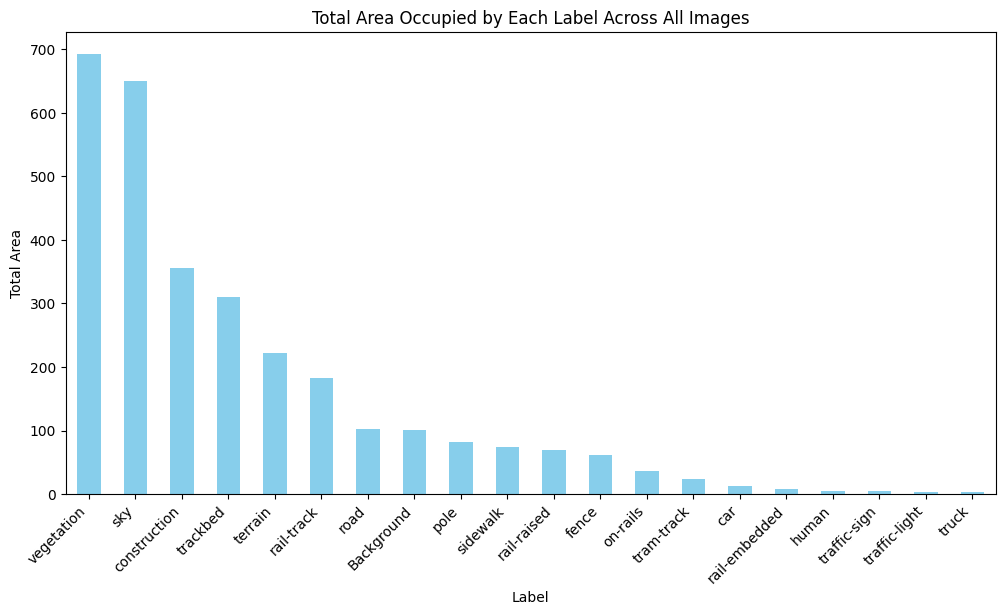

In [ ]:
# Flatten the lists in 'Unique Labels' and 'Area of Objects' columns
flat_labels = [id2label[str(label)] if label != 255 else "Background" for labels_list in df['Unique Labels'] for label in labels_list]
flat_areas = [area for areas_list in df['Area of Objects'] for area in areas_list]
print(flat_labels)
# Create a DataFrame with flattened data
area_df = pd.DataFrame({'Label': flat_labels, 'Area': flat_areas})
print(area_df.head(20))
# Group by label and sum the areas
label_areas = area_df.groupby('Label')['Area'].sum()
print(label_areas)
label_areas = label_areas.sort_values(ascending=False)

# Plot the histogram or bar plot
plt.figure(figsize=(12, 6))
label_areas.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Total Area')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Total Area Occupied by Each Label Across All Images')
plt.show()

           Labels  Counts
0            road  624717
1        sidewalk   89822
2    construction  970974
3      tram-track  122994
4           fence    2949
5            pole    3924
6   traffic-light      31
7    traffic-sign    1920
8      vegetation   35285
9             sky     269
10          human   27388
11            car   13682
12  rail-embedded   95845
13     Background   83800
14           road   78252
15       sidewalk   17596
16   construction  130932
17          fence   30541
18           pole  153414
19  traffic-light   16101
Labels
vegetation       1436245852
sky              1348733922
construction      737772711
trackbed          642478167
terrain           459797900
rail-track        379655511
road              210950946
Background        208510757
pole              169498139
sidewalk          154017369
rail-raised       145280866
fence             127304617
on-rails           75357708
tram-track         50333619
car                24846830
rail-embedded      16770198

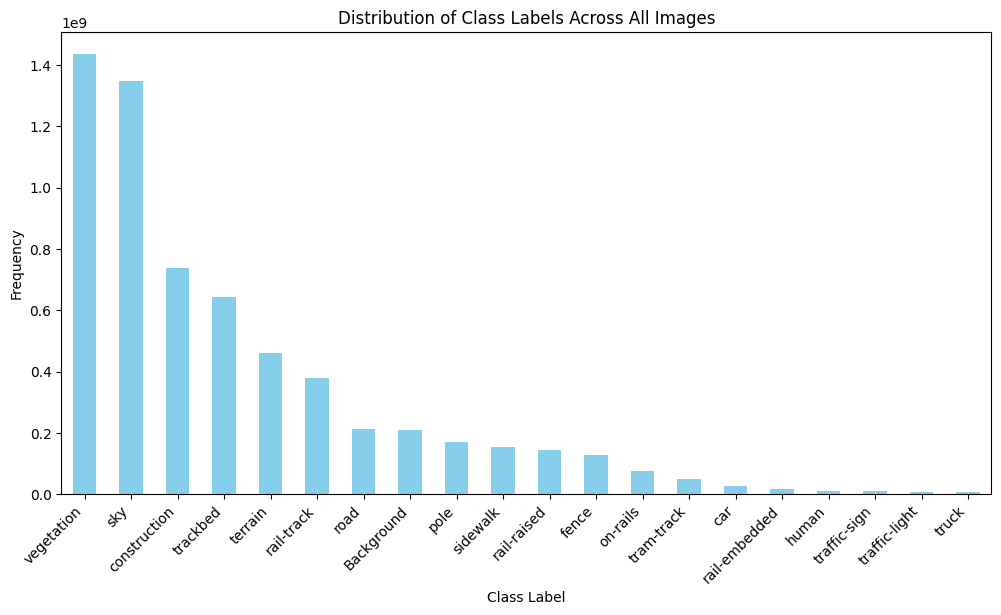

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Combine label and count data for all images
all_labels = [label for labels_per_image in df['Unique Labels'] for label in labels_per_image]
all_counts = [count for counts_per_image in df['Label Counts'] for count in counts_per_image]

#convert to df
label_df = pd.DataFrame({'Labels': all_labels, 'Counts': all_counts})

# Apply id2label mapping to the 'Labels' column
label_df['Labels'] = label_df['Labels'].astype(str)
label_df['Labels'] = label_df['Labels'].map(lambda x: id2label.get(x, 'Background'))
#get the counts per label
label_counts = label_df.groupby('Labels')['Counts'].sum()
label_counts = label_counts.sort_values(ascending=False)
print(label_df.head(20))
print(label_counts)

# Plot the histogram or bar plot
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels Across All Images')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

In [ ]:
len(all_labels), len(all_counts), np.unique(all_labels), label_counts

(41432,
 41432,
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18, 255]),
 Labels
 vegetation       1436245852
 sky              1348733922
 construction      737772711
 trackbed          642478167
 terrain           459797900
 rail-track        379655511
 road              210950946
 Background        208510757
 pole              169498139
 sidewalk          154017369
 rail-raised       145280866
 fence             127304617
 on-rails           75357708
 tram-track         50333619
 car                24846830
 rail-embedded      16770198
 human               8781279
 traffic-sign        8357024
 traffic-light       8312624
 truck               7793961
 Name: Counts, dtype: int64)

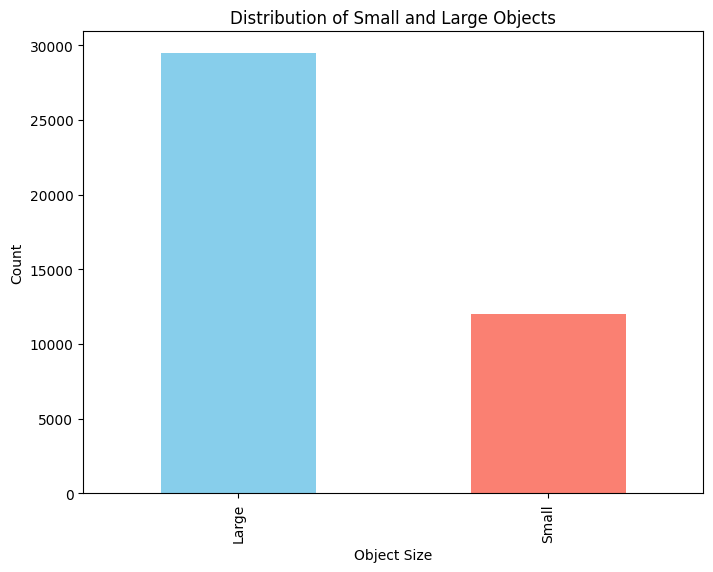

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define threshold to distinguish small and large objects
threshold = 0.004  # You can adjust this value based on your specific criteria

# Create an empty list to store DataFrames for each row
dfs = []

# Iterate through rows of the original DataFrame
for index, row in df.iterrows():
    labels = row['Unique Labels']
    areas = row['Area of Objects']

    # Create a DataFrame for the current row
    objects_df_row = pd.DataFrame({'Label': labels, 'Area': areas})

    # Categorize object sizes based on the threshold
    objects_df_row['Object Size'] = ['Small' if area <= threshold else 'Large' for area in areas]

    # Append the DataFrame for the current row to the list
    dfs.append(objects_df_row)

# Concatenate all DataFrames into a single DataFrame
objects_df = pd.concat(dfs, ignore_index=True)

# Analyze statistics
size_counts = objects_df['Object Size'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
size_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Object Size')
plt.ylabel('Count')
plt.title('Distribution of Small and Large Objects')
plt.show()


In [ ]:
color_palette = labels_info["color_palette"]
my_palette = {i: color for i, color in enumerate(color_palette)}
my_palette[255] = [0, 0, 0]
my_palette

{0: [128, 64, 128],
 1: [244, 35, 232],
 2: [70, 70, 70],
 3: [192, 0, 128],
 4: [190, 153, 153],
 5: [153, 153, 153],
 6: [250, 170, 30],
 7: [220, 220, 0],
 8: [107, 142, 35],
 9: [152, 251, 152],
 10: [70, 130, 180],
 11: [220, 20, 60],
 12: [230, 150, 140],
 13: [0, 0, 142],
 14: [0, 0, 70],
 15: [90, 40, 40],
 16: [0, 80, 100],
 17: [0, 254, 254],
 18: [0, 68, 63],
 255: [0, 0, 0]}

<Figure size 800x800 with 0 Axes>

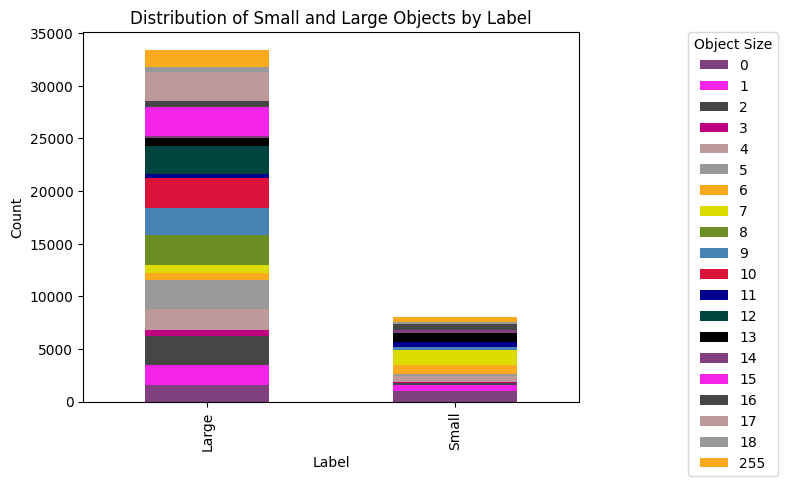

In [ ]:
# Create an empty list to store DataFrames for each row
dfs = []

# Assume you have a custom color palette for each class
color_palette = labels_info["color_palette"]
my_palette = {i: color for i, color in enumerate(color_palette)}
#my_palette[255] = [0, 0, 0]

# Convert RGB values to the required format (0.0 to 1.0)
class_palette_normalized = {k: [v_i / 255.0 for v_i in v] for k, v in my_palette.items()}
class_palette_normalized[255] = [0, 0, 0]

# Iterate through rows of the original DataFrame
for index, row in df.iterrows():
    labels = row['Unique Labels']
    areas = row['Area of Objects']

    # Create a DataFrame for the current row
    objects_df_row = pd.DataFrame({'Label': labels, 'Area': areas})

    # Map class labels to their respective colors
    objects_df_row['Color'] = objects_df_row['Label'].map(class_palette_normalized)
    # Apply id2label mapping to the 'Labels' column
    # objects_df_row['Label'] = objects_df_row['Label'].astype(str)
    # objects_df_row['Label'] = objects_df_row['Label'].map(lambda x: id2label.get(x, 'Background'))

    # Categorize object sizes based on the threshold
    objects_df_row['Object Size'] = ['Small' if area <= threshold else 'Large' for area in areas]

    # Append the DataFrame for the current row to the list
    dfs.append(objects_df_row)

# Concatenate all DataFrames into a single DataFrame
objects_df = pd.concat(dfs, ignore_index=True)

# Set up a custom color palette
custom_palette = [tuple(color) for color in objects_df['Color']]

# Analyze statistics
size_label_counts = objects_df.groupby(['Object Size', 'Label']).size().unstack(fill_value=0)

# Plot the distribution using a stacked bar plot with custom palette
plt.figure(figsize=(8, 8))
size_label_counts.plot(kind='bar', stacked=True, color=custom_palette)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Small and Large Objects by Label')
plt.legend(title='Object Size', loc="upper right", bbox_to_anchor=(1.4, 1), borderaxespad=0.)
plt.show()

In [ ]:
class_palette_normalized

{0: [0.5019607843137255, 0.25098039215686274, 0.5019607843137255],
 1: [0.9568627450980393, 0.13725490196078433, 0.9098039215686274],
 2: [0.27450980392156865, 0.27450980392156865, 0.27450980392156865],
 3: [0.7529411764705882, 0.0, 0.5019607843137255],
 4: [0.7450980392156863, 0.6, 0.6],
 5: [0.6, 0.6, 0.6],
 6: [0.9803921568627451, 0.6666666666666666, 0.11764705882352941],
 7: [0.8627450980392157, 0.8627450980392157, 0.0],
 8: [0.4196078431372549, 0.5568627450980392, 0.13725490196078433],
 9: [0.596078431372549, 0.984313725490196, 0.596078431372549],
 10: [0.27450980392156865, 0.5098039215686274, 0.7058823529411765],
 11: [0.8627450980392157, 0.0784313725490196, 0.23529411764705882],
 12: [0.9019607843137255, 0.5882352941176471, 0.5490196078431373],
 13: [0.0, 0.0, 0.5568627450980392],
 14: [0.0, 0.0, 0.27450980392156865],
 15: [0.35294117647058826, 0.1568627450980392, 0.1568627450980392],
 16: [0.0, 0.3137254901960784, 0.39215686274509803],
 17: [0.0, 0.996078431372549, 0.9960784313

<Figure size 800x800 with 0 Axes>

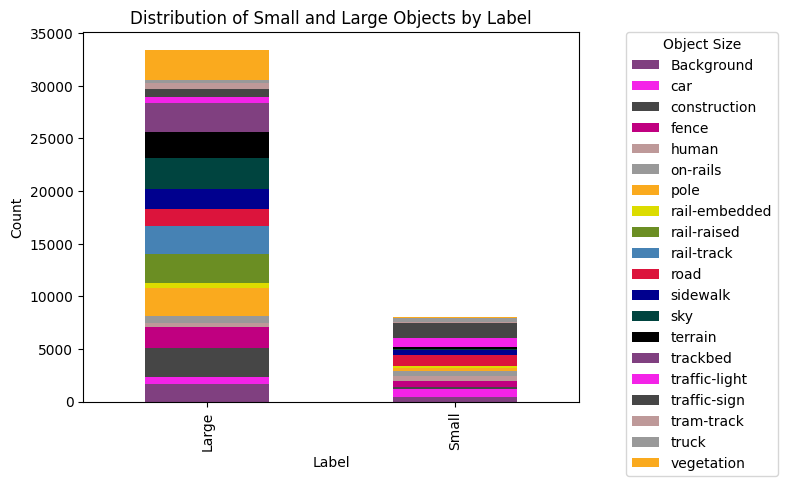

In [ ]:
# Create an empty list to store DataFrames for each row
dfs = []

# Assume you have a custom color palette for each class
color_palette = labels_info["color_palette"]
my_palette = {i: color for i, color in enumerate(color_palette)}
#my_palette[255] = [0, 0, 0]

# Convert RGB values to the required format (0.0 to 1.0)
class_palette_normalized = {k: [v_i / 255.0 for v_i in v] for k, v in my_palette.items()}
class_palette_normalized[255] = [0, 0, 0]

# Iterate through rows of the original DataFrame
for index, row in df.iterrows():
    labels = row['Unique Labels']
    areas = row['Area of Objects']

    # Create a DataFrame for the current row
    objects_df_row = pd.DataFrame({'Label': labels, 'Area': areas})

    # Map class labels to their respective colors
    objects_df_row['Color'] = objects_df_row['Label'].map(class_palette_normalized)
    # Apply id2label mapping to the 'Labels' column
    objects_df_row['Label'] = objects_df_row['Label'].astype(str)
    objects_df_row['Label'] = objects_df_row['Label'].map(lambda x: id2label.get(x, 'Background'))

    # Categorize object sizes based on the threshold
    objects_df_row['Object Size'] = ['Small' if area <= threshold else 'Large' for area in areas]

    # Append the DataFrame for the current row to the list
    dfs.append(objects_df_row)

# Concatenate all DataFrames into a single DataFrame
objects_df = pd.concat(dfs, ignore_index=True)

# Set up a custom color palette
custom_palette = [tuple(color) for color in objects_df['Color']]

# Analyze statistics
size_label_counts = objects_df.groupby(['Object Size', 'Label']).size().unstack(fill_value=0)

# Plot the distribution using a stacked bar plot with custom palette
plt.figure(figsize=(8, 8))
size_label_counts.plot(kind='bar', stacked=True, color=custom_palette)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Small and Large Objects by Label')
plt.legend(title='Object Size', loc="upper right", bbox_to_anchor=(1.4, 1), borderaxespad=0.)
plt.show()